In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'NFLX.csv'
stock_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


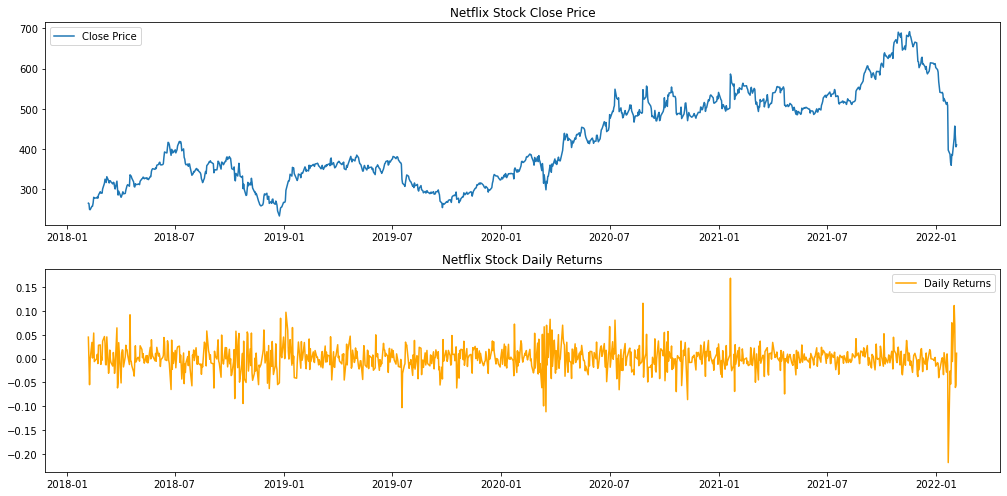

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Convert the Date column to datetime type
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Normalize the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data['Normalized_Close'] = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

# Calculate the daily returns (percentage change in 'Close' price)
stock_data['Daily_Returns'] = stock_data['Close'].pct_change()

# Drop the first row since it will be a NaN value after pct_change()
stock_data.dropna(inplace=True)

# Plotting the original 'Close' price and the 'Daily_Returns'
plt.figure(figsize=(14,7))

# Subplot for the 'Close' price
plt.subplot(2, 1, 1)
plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price')
plt.title('Netflix Stock Close Price')
plt.legend()

# Subplot for the 'Daily_Returns'
plt.subplot(2, 1, 2)
plt.plot(stock_data['Date'], stock_data['Daily_Returns'], label='Daily Returns', color='orange')
plt.title('Netflix Stock Daily Returns')
plt.legend()

plt.tight_layout()
plt.show()

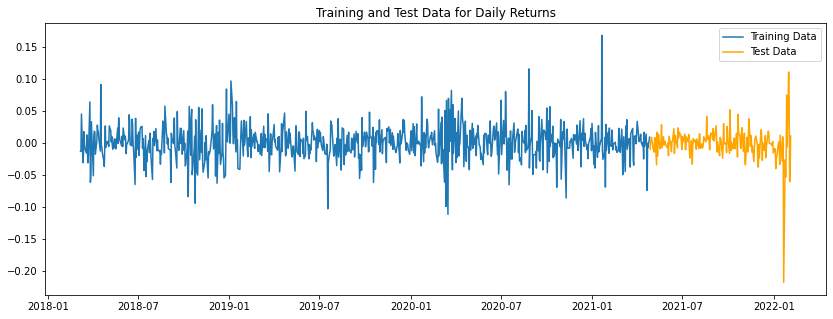

((790, 20, 1), (198, 20, 1))

In [3]:
import numpy as np

# Function to create sequences and corresponding labels
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:(i + sequence_length)])
        ys.append(data[i + sequence_length])
    return np.array(xs), np.array(ys)

# Define sequence length (number of time steps)
sequence_length = 20  # Use last 20 days to predict the next day

# Generate the sequences and labels using 'Daily_Returns'
data = stock_data['Daily_Returns'].values
X, y = create_sequences(data, sequence_length)

# Reshape features for the RNN model (batch_size, sequence_length, num_features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Visualize the training data
plt.figure(figsize=(14,5))
plt.plot(stock_data['Date'][sequence_length:train_size+sequence_length], y_train, label='Training Data')
plt.plot(stock_data['Date'][train_size+sequence_length:], y_test, label='Test Data', color='orange')
plt.title('Training and Test Data for Daily Returns')
plt.legend()
plt.show()

X_train.shape, X_test.shape

Training data shape: torch.Size([790, 20, 1])
Test data shape: torch.Size([198, 20, 1])
Training labels shape: torch.Size([790])
Test labels shape: torch.Size([198])


c:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 loss: 4.281694418750703e-05
Epoch 5 loss: 3.6136429116595536e-05
Epoch 10 loss: 5.196358688408509e-05
Epoch 15 loss: 6.140110053820536e-05
Epoch 20 loss: 6.207613478181884e-05
Epoch 25 loss: 5.629136285278946e-05
Epoch 30 loss: 7.215962978079915e-05
Epoch 35 loss: 6.157183815957978e-05
Epoch 40 loss: 0.00010190199827775359
Epoch 45 loss: 8.215732668759301e-05
Epoch 50 loss: 7.57515590521507e-05
Epoch 55 loss: 7.086732512107119e-05
Epoch 60 loss: 6.0530110204126686e-05
Epoch 65 loss: 3.8964779378147796e-05
Epoch 70 loss: 3.8421814679168165e-05
Epoch 75 loss: 7.540509250247851e-05
Epoch 80 loss: 3.666290285764262e-05
Epoch 85 loss: 2.5529676349833608e-05
Epoch 90 loss: 2.7607191441347823e-05
Epoch 95 loss: 1.8850420019589365e-05


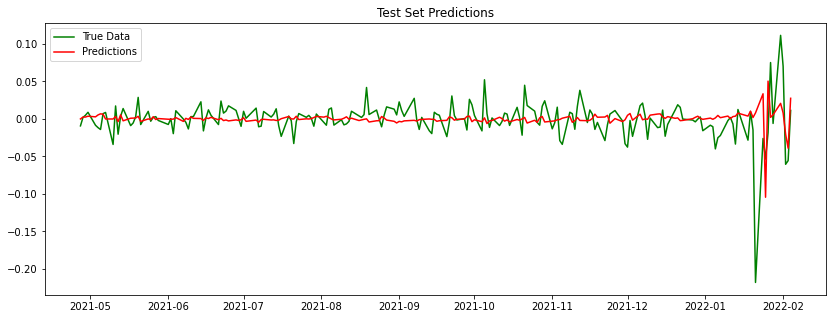

(0.0006481058894153054, 0.02545792390230015)

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, input_seq.size(1), self.hidden_layer_size).to(input_seq.device)
        # Initialize cell state
        c0 = torch.zeros(1, input_seq.size(1), self.hidden_layer_size).to(input_seq.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(input_seq, (h0, c0))  
        # out: tensor of shape (seq_length, batch_size, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.linear(out[-1, :, :])
        return out


# Instantiate the model, define the loss function and the optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Prepare data for PyTorch
X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)

# Convert labels to tensors
y_train_tensor = torch.Tensor(y_train)
y_test_tensor = torch.Tensor(y_test)

# Check shapes
print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")
print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Test labels shape: {y_test_tensor.shape}")

# Training the model
epochs = 100

for i in range(epochs):
    model.train()
    for seq, labels in zip(X_train_tensor, y_train_tensor):
        optimizer.zero_grad()
        
        # Forward pass through the network
        y_pred = model(seq.unsqueeze(1))
        
        # Compute the loss, gradients, and update the weights
        # Ensure labels and predictions have the same shape
        single_loss = loss_function(y_pred.view(-1), labels)
        single_loss.backward()
        optimizer.step()

    # Optional: print the loss at the specified interval
    if i % 5 == 0:
        print(f'Epoch {i} loss: {single_loss.item()}')

# Making predictions on the test set
model.eval()
test_predictions = []
with torch.no_grad():
    for seq in X_test_tensor:
        test_preds = model(seq.unsqueeze(1))
        test_predictions.append(test_preds.squeeze().item())

# Convert predictions list to numpy array
test_predictions = np.array(test_predictions)
y_test = y_test_tensor.numpy()

# Calculating the performance metrics
mse = ((test_predictions - y_test) ** 2).mean()
rmse = np.sqrt(mse)

# Plotting the predictions against the actual values
plt.figure(figsize=(14,5))
plt.plot(stock_data['Date'][train_size+sequence_length:], y_test, label='True Data', color='green')
plt.plot(stock_data['Date'][train_size+sequence_length:], test_predictions, label='Predictions', color='red')
plt.title('Test Set Predictions')
plt.legend()
plt.show()

mse, rmse

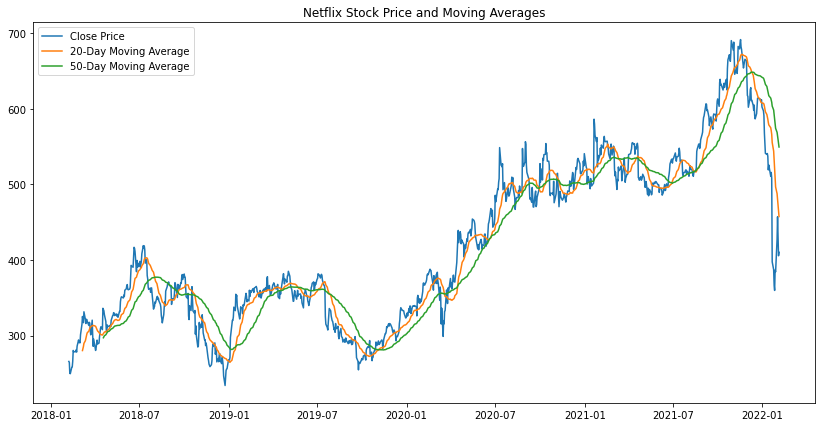

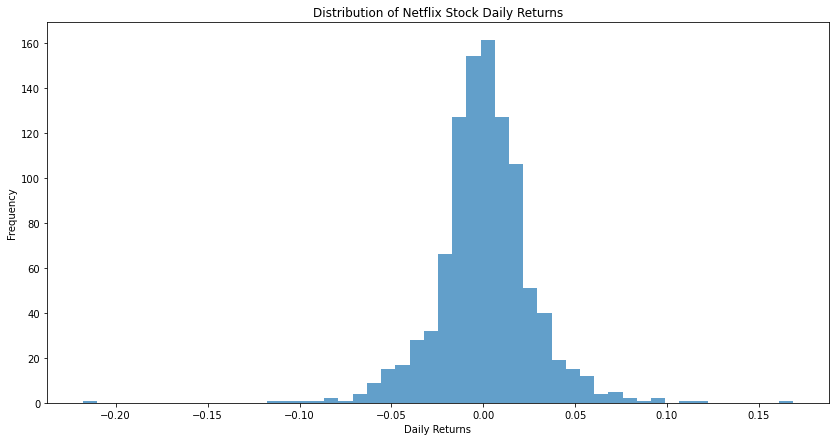

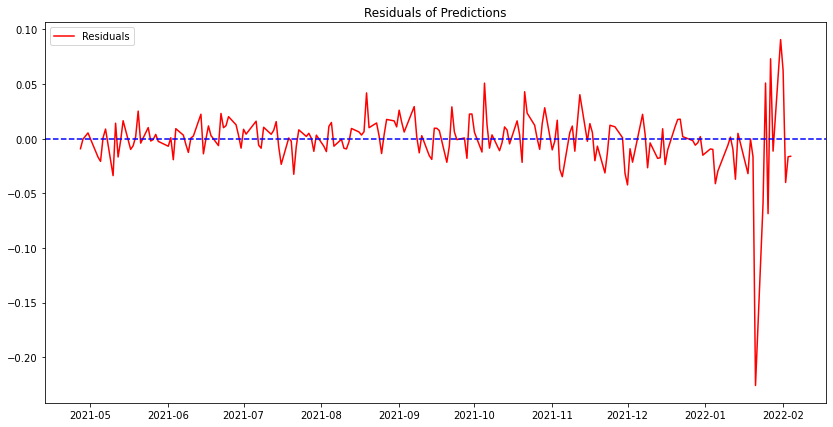

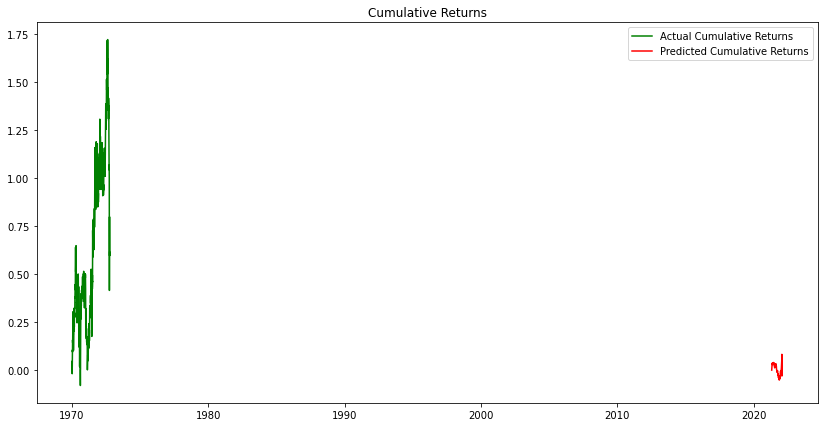

In [5]:
# Moving Average
stock_data['20d'] = stock_data['Close'].rolling(window=20).mean()
stock_data['50d'] = stock_data['Close'].rolling(window=50).mean()

plt.figure(figsize=(14,7))
plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price')
plt.plot(stock_data['Date'], stock_data['20d'], label='20-Day Moving Average')
plt.plot(stock_data['Date'], stock_data['50d'], label='50-Day Moving Average')
plt.title('Netflix Stock Price and Moving Averages')
plt.legend()
plt.show()

# Price Change Distribution
plt.figure(figsize=(14,7))
plt.hist(stock_data['Daily_Returns'], bins=50, alpha=0.7)
plt.title('Distribution of Netflix Stock Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

# Residuals Plot
residuals = y_test - test_predictions
plt.figure(figsize=(14,7))
plt.plot(stock_data['Date'][train_size+sequence_length:], residuals, label='Residuals', color='red')
plt.title('Residuals of Predictions')
plt.axhline(y=0, color='blue', linestyle='--')
plt.legend()
plt.show()

# Cumulative Returns
cumulative_returns_actual = (1 + stock_data['Daily_Returns']).cumprod() - 1
cumulative_returns_predicted = (1 + pd.Series(test_predictions, index=stock_data['Date'][train_size+sequence_length:])).cumprod() - 1

plt.figure(figsize=(14,7))
plt.plot(cumulative_returns_actual, label='Actual Cumulative Returns', color='green')
plt.plot(cumulative_returns_predicted, label='Predicted Cumulative Returns', color='red')
plt.title('Cumulative Returns')
plt.legend()
plt.show()
